# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from stats import  full_bootstrap_mean_diff, standardize_data, bootstrap_expected_mean_difference

# strategies

Перед тем, как сравнивать частоту употребления стратегий в группах, стоит убедиться, что нету для каждой из стратегий зависимости между тем, сколько человек сказал слов


In [2]:
strats_ = pd.read_csv('strategies_fractions.tsv', sep='\t')
strats_.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type
0,pr_A_1,0.227273,0.113636,0.295455,0.363636,senior academics
1,pr_B_1,0.196078,0.058824,0.313725,0.431373,senior academics
2,pr_E_1,0.096154,0.019231,0.192308,0.692308,senior academics
3,pr_G_1,0.254545,0.018182,0.127273,0.600000,senior academics


In [3]:
strats = pd.read_csv('strategies_counts.tsv', sep='\t')
strats.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics
1,pr_B_1,10.0,3.0,16.0,22,51.0,senior academics
2,pr_E_1,5.0,1.0,10.0,36,52.0,senior academics
3,pr_G_1,14.0,1.0,7.0,33,55.0,senior academics


<Axes: xlabel='strat_sum', ylabel='phonetic strategy'>

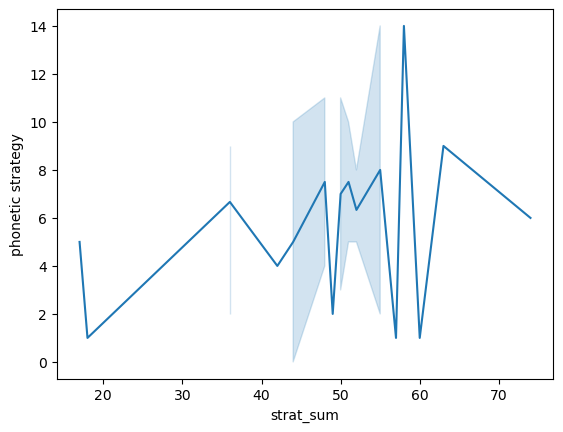

In [4]:
sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='phonetic strategy')

<Axes: xlabel='phonetic strategy', ylabel='Count'>

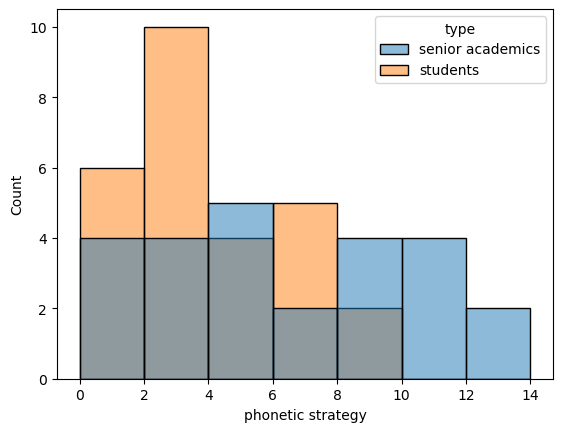

In [5]:
# sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='fonetics');
sns.histplot(strats, x='phonetic strategy',hue='type')

## количество сказанных слов

In [18]:
res = stats.normaltest(strats[strats['type']!='senior academics']['strat_sum'])
res

NormaltestResult(statistic=7.971465675012011, pvalue=0.01857882407353406)

Наблюдаемая разница средних (стандартизированная): -0.2703303465662201
p-значение: 0.54
Доверительный интервал (95%): [-0.79892369  0.24700149]


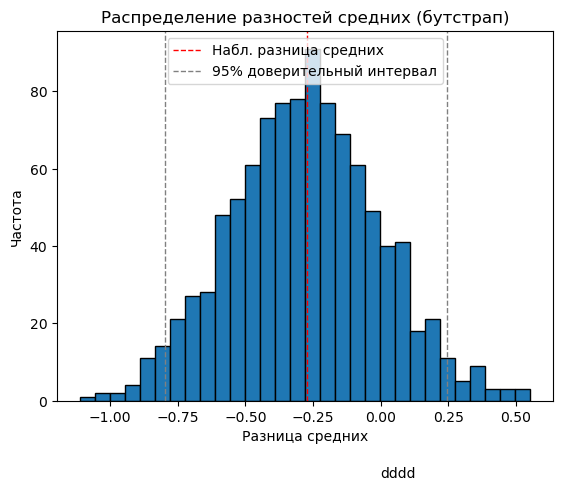

Разница средних при t-тесте (стандартизированная): -0.2703303465662201
p-значение при t-тесте: 0.3350066096207589


In [19]:
# 1. Стандартизация данных
def standardize_data(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df[column + '_standardized'] = (df[column] - mean) / std
    return df

strats = standardize_data(strats, 'strat_sum')


# 2. Бутстрап для сравнения стандартизированных средних
def bootstrap_mean_difference(group1, group2, num_iterations=1000):
    mean_diffs = []
    n1 = len(group1)
    n2 = len(group2)

    for _ in range(num_iterations):
        # Сэмплирование с возвращением
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        mean_diffs.append(mean_diff)

    return np.array(mean_diffs)

# Выбираем стандартизированные данные
group1 = strats[strats['type'] != 'senior academics']['strat_sum_standardized'].values
group2 = strats[strats['type'] == 'senior academics']['strat_sum_standardized'].values


mean_diffs_bootstrap = bootstrap_mean_difference(group1, group2)

# Вычисляем p-value и доверительный интервал
observed_diff = np.mean(group1) - np.mean(group2)
p_value = np.mean(np.abs(mean_diffs_bootstrap) >= np.abs(observed_diff))
ci = np.percentile(mean_diffs_bootstrap, [2.5, 97.5])


# Вывод результатов
print("Наблюдаемая разница средних (стандартизированная):", observed_diff)
print("p-значение:", p_value)
print("Доверительный интервал (95%):", ci)

# Строим гистограмму распределения разностей средних
plt.hist(mean_diffs_bootstrap, bins=30, edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=1, label=f'Набл. разница средних')
plt.axvline(ci[0], color='grey', linestyle='dashed', linewidth=1, label=f'95% доверительный интервал')
plt.axvline(ci[1], color='grey', linestyle='dashed', linewidth=1)
plt.title('Распределение разностей средних (бутстрап)')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.text(0, -20, 'dddd', fontsize=10)
plt.legend()
plt.show()


# Сравнение с t-тестом (для сравнения) - выводим только p-value и разницу средних
t_stat, p_value_ttest = stats.ttest_ind(group1, group2)
print("Разница средних при t-тесте (стандартизированная):", np.mean(group1) - np.mean(group2))
print("p-значение при t-тесте:", p_value_ttest)


между группами академиков и студентов принята гипотеза об отсутствии разницы между средними количества сказанных слов

In [20]:
stats.ttest_ind(strats[strats['type']!='senior academics']['strat_sum'], strats[strats['type']=='senior academics']['strat_sum'])

TtestResult(statistic=-0.9734686470663446, pvalue=0.33500660962075846, df=50.0)

## доказать независимость частот с определенной стратегией от количества сказанных слов

### доказать независимость частот со стратегией "фонетика" от количества сказанных слов

In [21]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.pearsonr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.pearsonr(x, y)
print(res_exact.pvalue, res_asymptotic.pvalue) # asymptotic pvalue is too low
print(res_exact)

0.9068 0.9065481618184839
PermutationTestResult(statistic=-0.016684009954635075, pvalue=0.9068, null_distribution=array([ 0.08618607,  0.14868647, -0.28425339, ..., -0.09562836,
       -0.0273431 , -0.02662816]))


In [23]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.spearmanr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.spearmanr(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.3258, 0.32922028386214164)

In [24]:
res_exact

PermutationTestResult(statistic=0.1380092381063527, pvalue=0.3258, null_distribution=array([ 0.26246132, -0.15575756,  0.07843475, ..., -0.14335512,
       -0.11996155,  0.05726507]))

In [25]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.kendalltau(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.kendalltau(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.3804, 0.37141203727581673)

In [26]:
res_exact

PermutationTestResult(statistic=0.08712786184136909, pvalue=0.3804, null_distribution=array([ 0.        ,  0.09406725,  0.06708074, ..., -0.11719854,
       -0.09021203, -0.07479117]))

не отвергаем нулевую гипотезу, частота сказанных слов со стратегией фонетика не коррелирует со общим количеством сказанных слов

Более того, в этой связи есть линейность?

(0.0, 15.0)

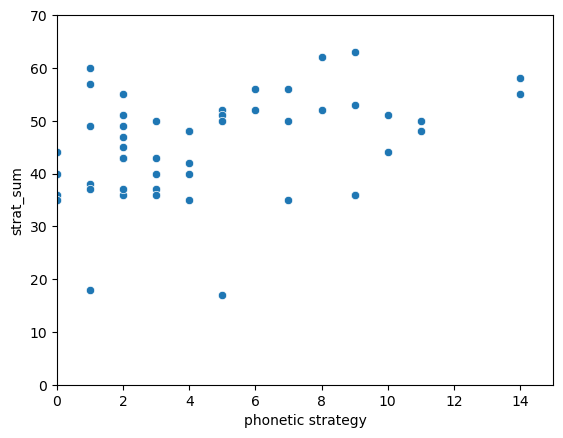

In [28]:
sns.scatterplot(strats, y='strat_sum', x='phonetic strategy');
plt.ylim(0,70)
plt.xlim(0,15)

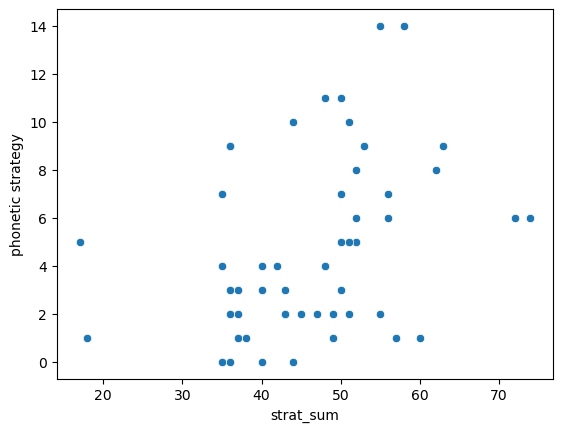

In [29]:
sns.scatterplot(strats, y='phonetic strategy', x='strat_sum');
# plt.ylim(0,70)
# plt.xlim(0,15)

поэтому не стоит сравнивать количества сказанных слов со стратегией фонетика напрямую, их надо нормализовывать по количеству сказанных слов

или стоит?? стоит, потому что на графике не видно связи, точки разбросаны

### доказать независимость частот со стратегией "лексика" от количества сказанных слов

In [30]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

## сравнение количества слов по стратегиям между группами

In [31]:
strats.head(1)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type,strat_sum_standardized
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics,-0.218


In [33]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

Observed mean difference (standardized): -0.2703303465662201
bootstrap p-value: 0.329
Confidence interval (95%): [-0.55900889  0.550578  ]
Cohen's d (effect size): -0.270191544552574


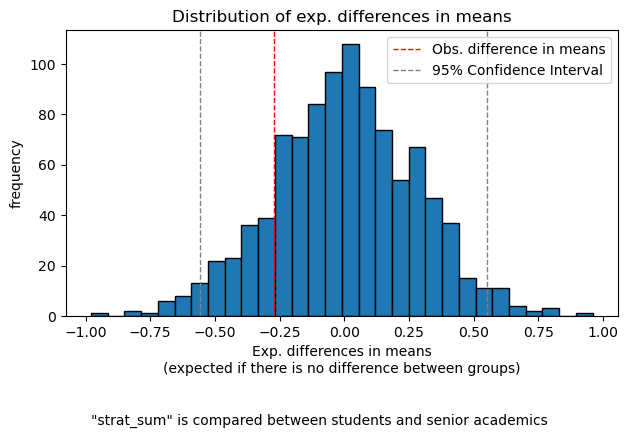

(array([-0.55900889,  0.550578  ]),
 0.329,
 -0.2703303465662201,
 -0.270191544552574)

In [32]:
full_bootstrap_mean_diff(strats, 'strat_sum')

принимаем нулевую гипотезу об отсутствии различий в среднем количестве сказанных слов

In [34]:
strategies_list = ['phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy']

Observed mean difference (standardized): -0.7115128827610983
bootstrap p-value: 0.008
Confidence interval (95%): [-0.52463934  0.53021705]
Cohen's d (effect size): -0.7548089691549669


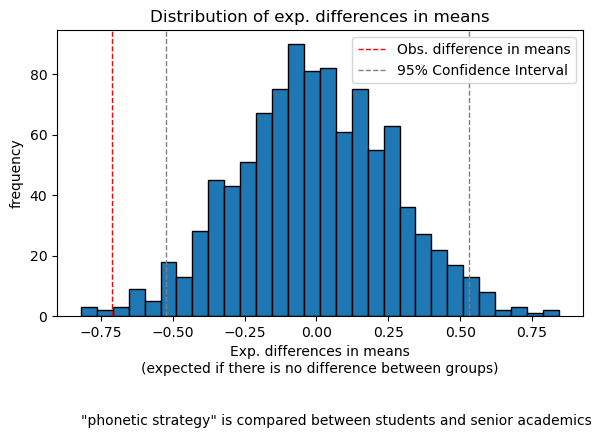

Observed mean difference (standardized): -0.0318556238103649
bootstrap p-value: 0.897
Confidence interval (95%): [-0.57893212  0.53562747]
Cohen's d (effect size): -0.03154584184871753


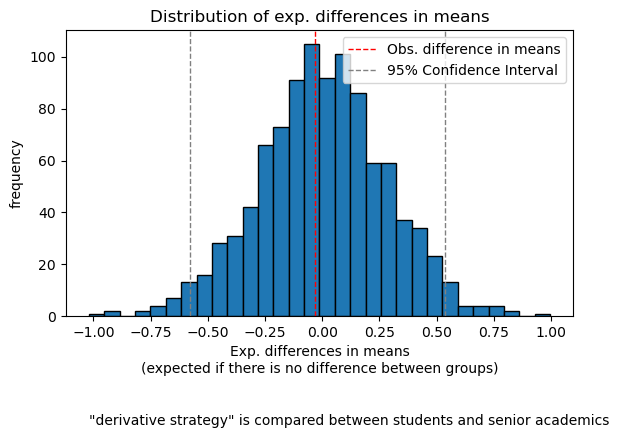

Observed mean difference (standardized): -0.8524593955322957
bootstrap p-value: 0.0
Confidence interval (95%): [-0.52955647  0.53143781]
Cohen's d (effect size): -0.934940850951001


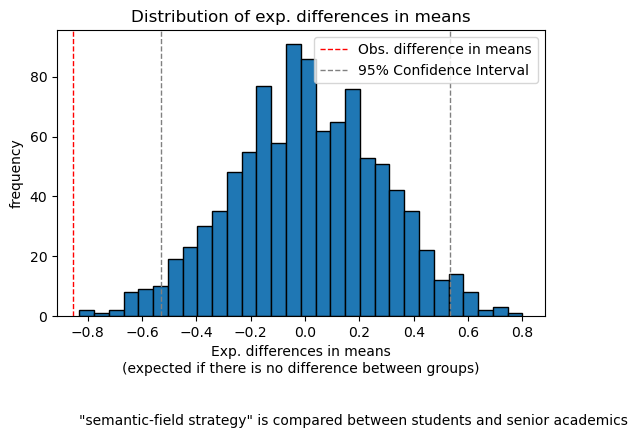

Observed mean difference (standardized): 0.4767813829282193
bootstrap p-value: 0.081
Confidence interval (95%): [-0.49840055  0.56779299]
Cohen's d (effect size): 0.48636373727938553


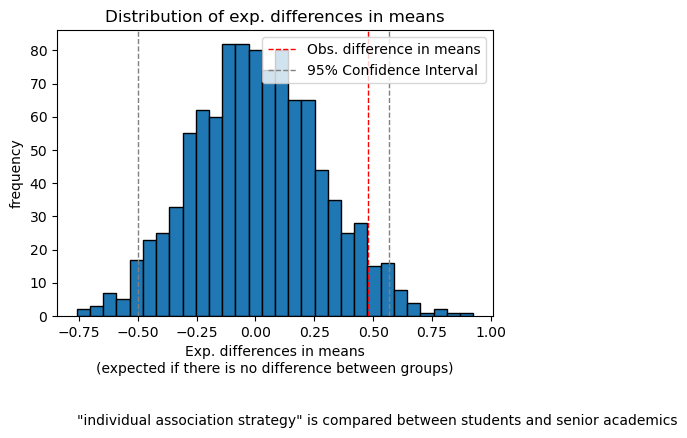

In [ ]:
pval = []
es = []
for i in strategies_list:
    ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
    pval.append(p_value)
    es.append(cohens_d)
    

In [36]:
strategies_list
#ofld

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [37]:
pval

[0.008, 0.897, 0.0, 0.081]

In [38]:
es

[-0.7548089691549669,
 -0.03154584184871753,
 -0.934940850951001,
 0.48636373727938553]

In [40]:
# plt.text(2.7, 257.5, f"ES = {es[3]:.1f}", rotation = 0, fontsize = 11
#          )       

# plt.text(2.7, 240, f"p value = {pval[3]:.3f}", rotation = 0, fontsize = 11 
#          )      

In [41]:
int(3/2)

1

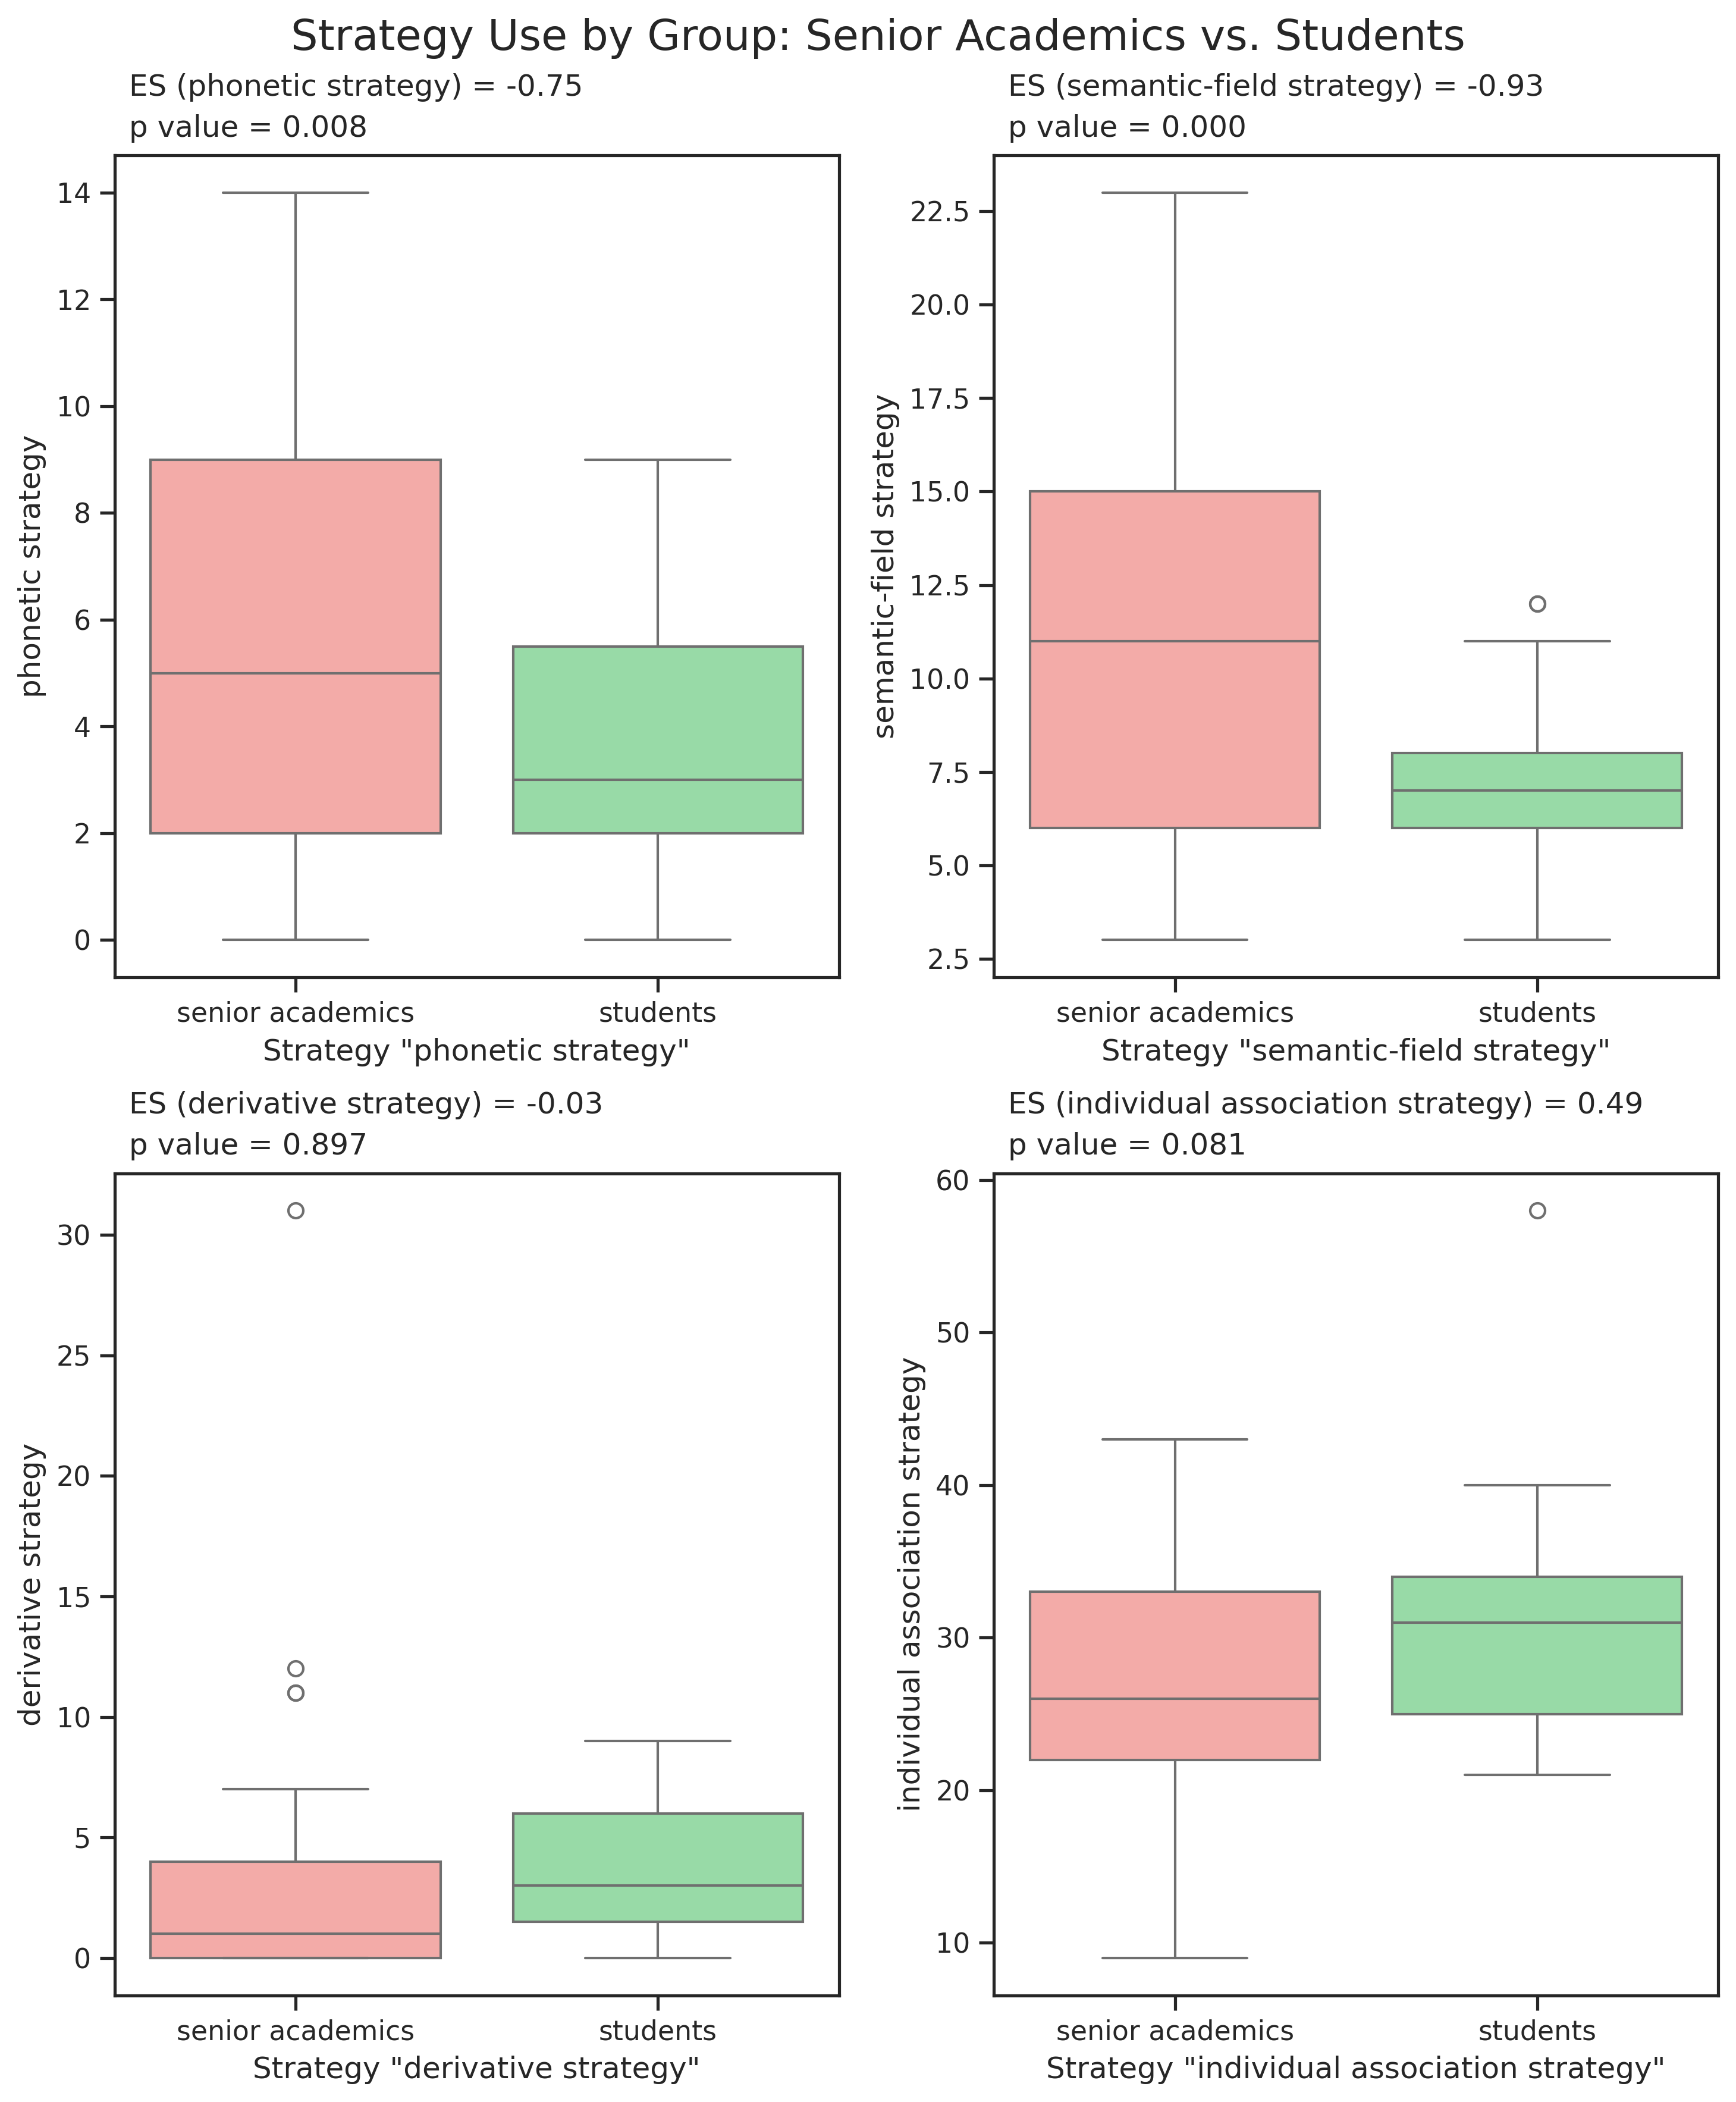

In [42]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 12), dpi=300)
j=0
for i in strategies_list:
    

    ax = sns.boxplot(strats, y=i, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
                     ,ax=axs[j%2][int(j/2)]
                     );
    
    ax.set_xlabel(f'Strategy "{i}"')

    ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
    ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)

    # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
    # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
    j+=1


# plt.xlabel('group')
# plt.title(f'Strategies between groups')
fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
plt.tight_layout()
plt.show();

## сравнение фракций для каждой стратегии между группами

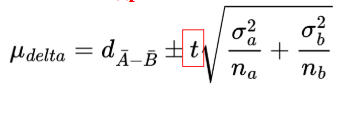

In [6]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

Observed difference (standardized): -0.7432813601897033
CI for observed difference [-1.2527854682388417, -0.23377725214056477]
Cohen's d (effect size): -0.7938888226496574
bootstrap p-value: 0.0
H0 Confidence interval (95%): [-0.38993925  0.39032238]
Expected mean diffs are normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


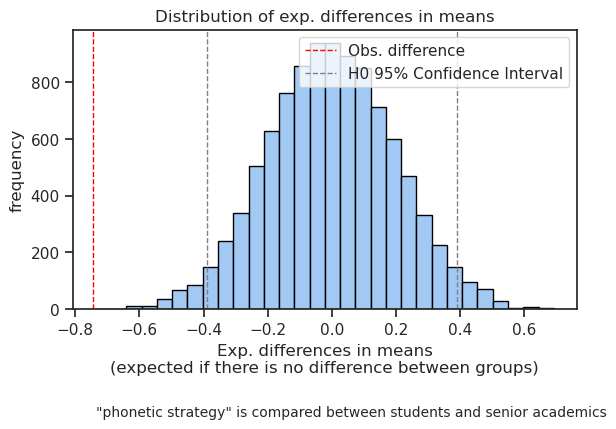

Observed difference (standardized): 0.17080970708216622
CI for observed difference [-0.3767182112090024, 0.7183376253733349]
Cohen's d (effect size): 0.16975829947896606
bootstrap p-value: 0.3878
H0 Confidence interval (95%): [-0.3851818   0.38215067]
Expected mean diffs are not normal disrtibuted


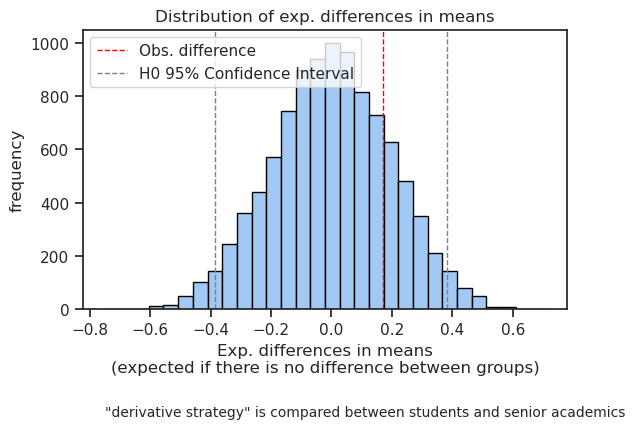

Observed difference (standardized): -0.8378024566518034
CI for observed difference [-1.3395167118500946, -0.33608820145351215]
Cohen's d (effect size): -0.9153318067798037
bootstrap p-value: 0.0
H0 Confidence interval (95%): [-0.37778427  0.38220324]
Expected mean diffs are normal disrtibuted


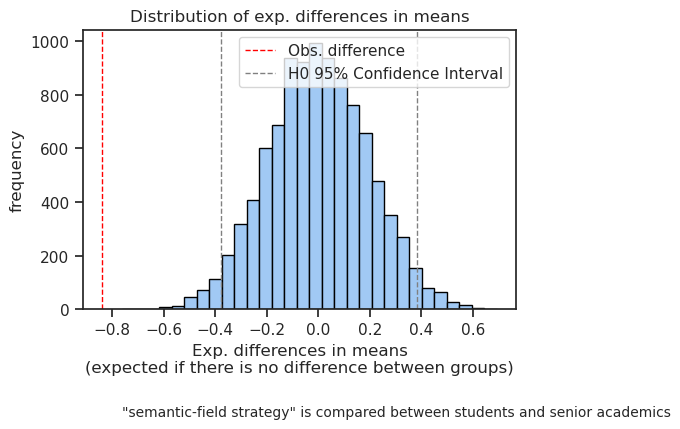

Observed difference (standardized): 0.8987988967047231
CI for observed difference [0.4105300614835094, 1.3870677319259368]
Cohen's d (effect size): 0.9984975293516468
bootstrap p-value: 0.0
H0 Confidence interval (95%): [-0.37519826  0.39484488]
Expected mean diffs are normal disrtibuted


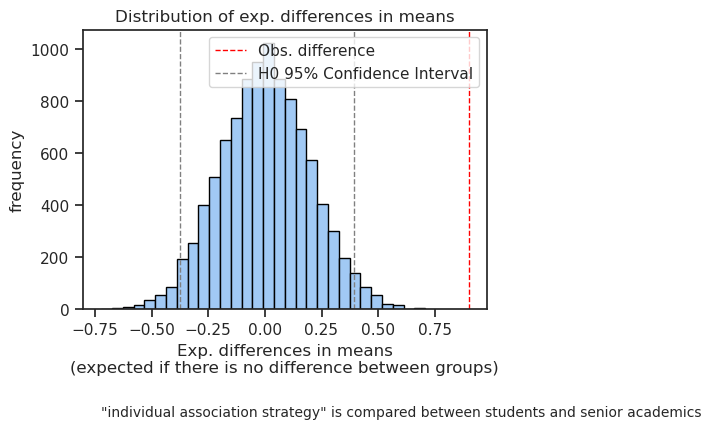

In [63]:
pval = []
es = []
for i in strategies_list:
    ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats_, i,num_it=10000)
    pval.append(p_value)
    es.append(cohens_d)

In [51]:
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [52]:
strats_.head()

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type,phonetic strategy_standardized,derivative strategy_standardized,semantic-field strategy_standardized,individual association strategy_standardized
0,pr_A_1,0.227273,0.113636,0.295455,0.363636,senior academics,1.599909,0.535599,1.116055,-2.028730
1,pr_B_1,0.196078,0.058824,0.313725,0.431373,senior academics,1.200585,-0.141556,1.322812,-1.513977
2,pr_E_1,0.096154,0.019231,0.192308,0.692308,senior academics,-0.078569,-0.630684,-0.051176,0.468966
3,pr_G_1,0.254545,0.018182,0.127273,0.600000,senior academics,1.949033,-0.643642,-0.787124,-0.232515
4,pr_I_1,0.083333,0.020833,0.187500,0.708333,senior academics,-0.242687,-0.610886,-0.105581,0.590751


In [53]:
strats_.describe()

,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,phonetic strategy_standardized,derivative strategy_standardized,semantic-field strategy_standardized,individual association strategy_standardized
count,52.000000,52.000000,52.000000,52.000000,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,0.102291,0.070282,0.196830,0.630597,-5.090746e-17,-5.551115e-17,2.268485e-16,-8.135853e-16
std,0.078118,0.080946,0.088369,0.131590,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,0.062500,0.313725,-1.309453e+00,-8.682597e-01,-1.520105e+00,-2.408021e+00
25%,0.043972,0.013636,0.139373,0.547532,-7.465640e-01,-6.997966e-01,-6.501909e-01,-6.312422e-01
50%,0.083333,0.043056,0.175735,0.639444,-2.426871e-01,-3.363532e-01,-2.387123e-01,6.723837e-02
75%,0.140714,0.113087,0.228145,0.721549,4.918577e-01,5.288062e-01,3.543624e-01,6.911794e-01
max,0.294118,0.418919,0.450980,0.886364,2.455604e+00,4.307047e+00,2.876016e+00,1.943669e+00


array([ 0.06210327, -0.27151863, -0.71404897, -0.61749689, -1.30945342,
       -0.02933384,  0.15354038,  0.29069605, -0.24268711, -0.41634674,
       -0.74051139, -1.04820453, -0.97257985,  0.48271399, -0.76472169,
       -0.80744574,  0.86433454,  1.25078574, -0.96347516, -0.34936374,
        0.34231378])

In [43]:
a = strats_[strats_['type']=='students']['derivative strategy_standardized'].unique()
b = strats_[strats_['type']!='students']['derivative strategy_standardized'].unique()

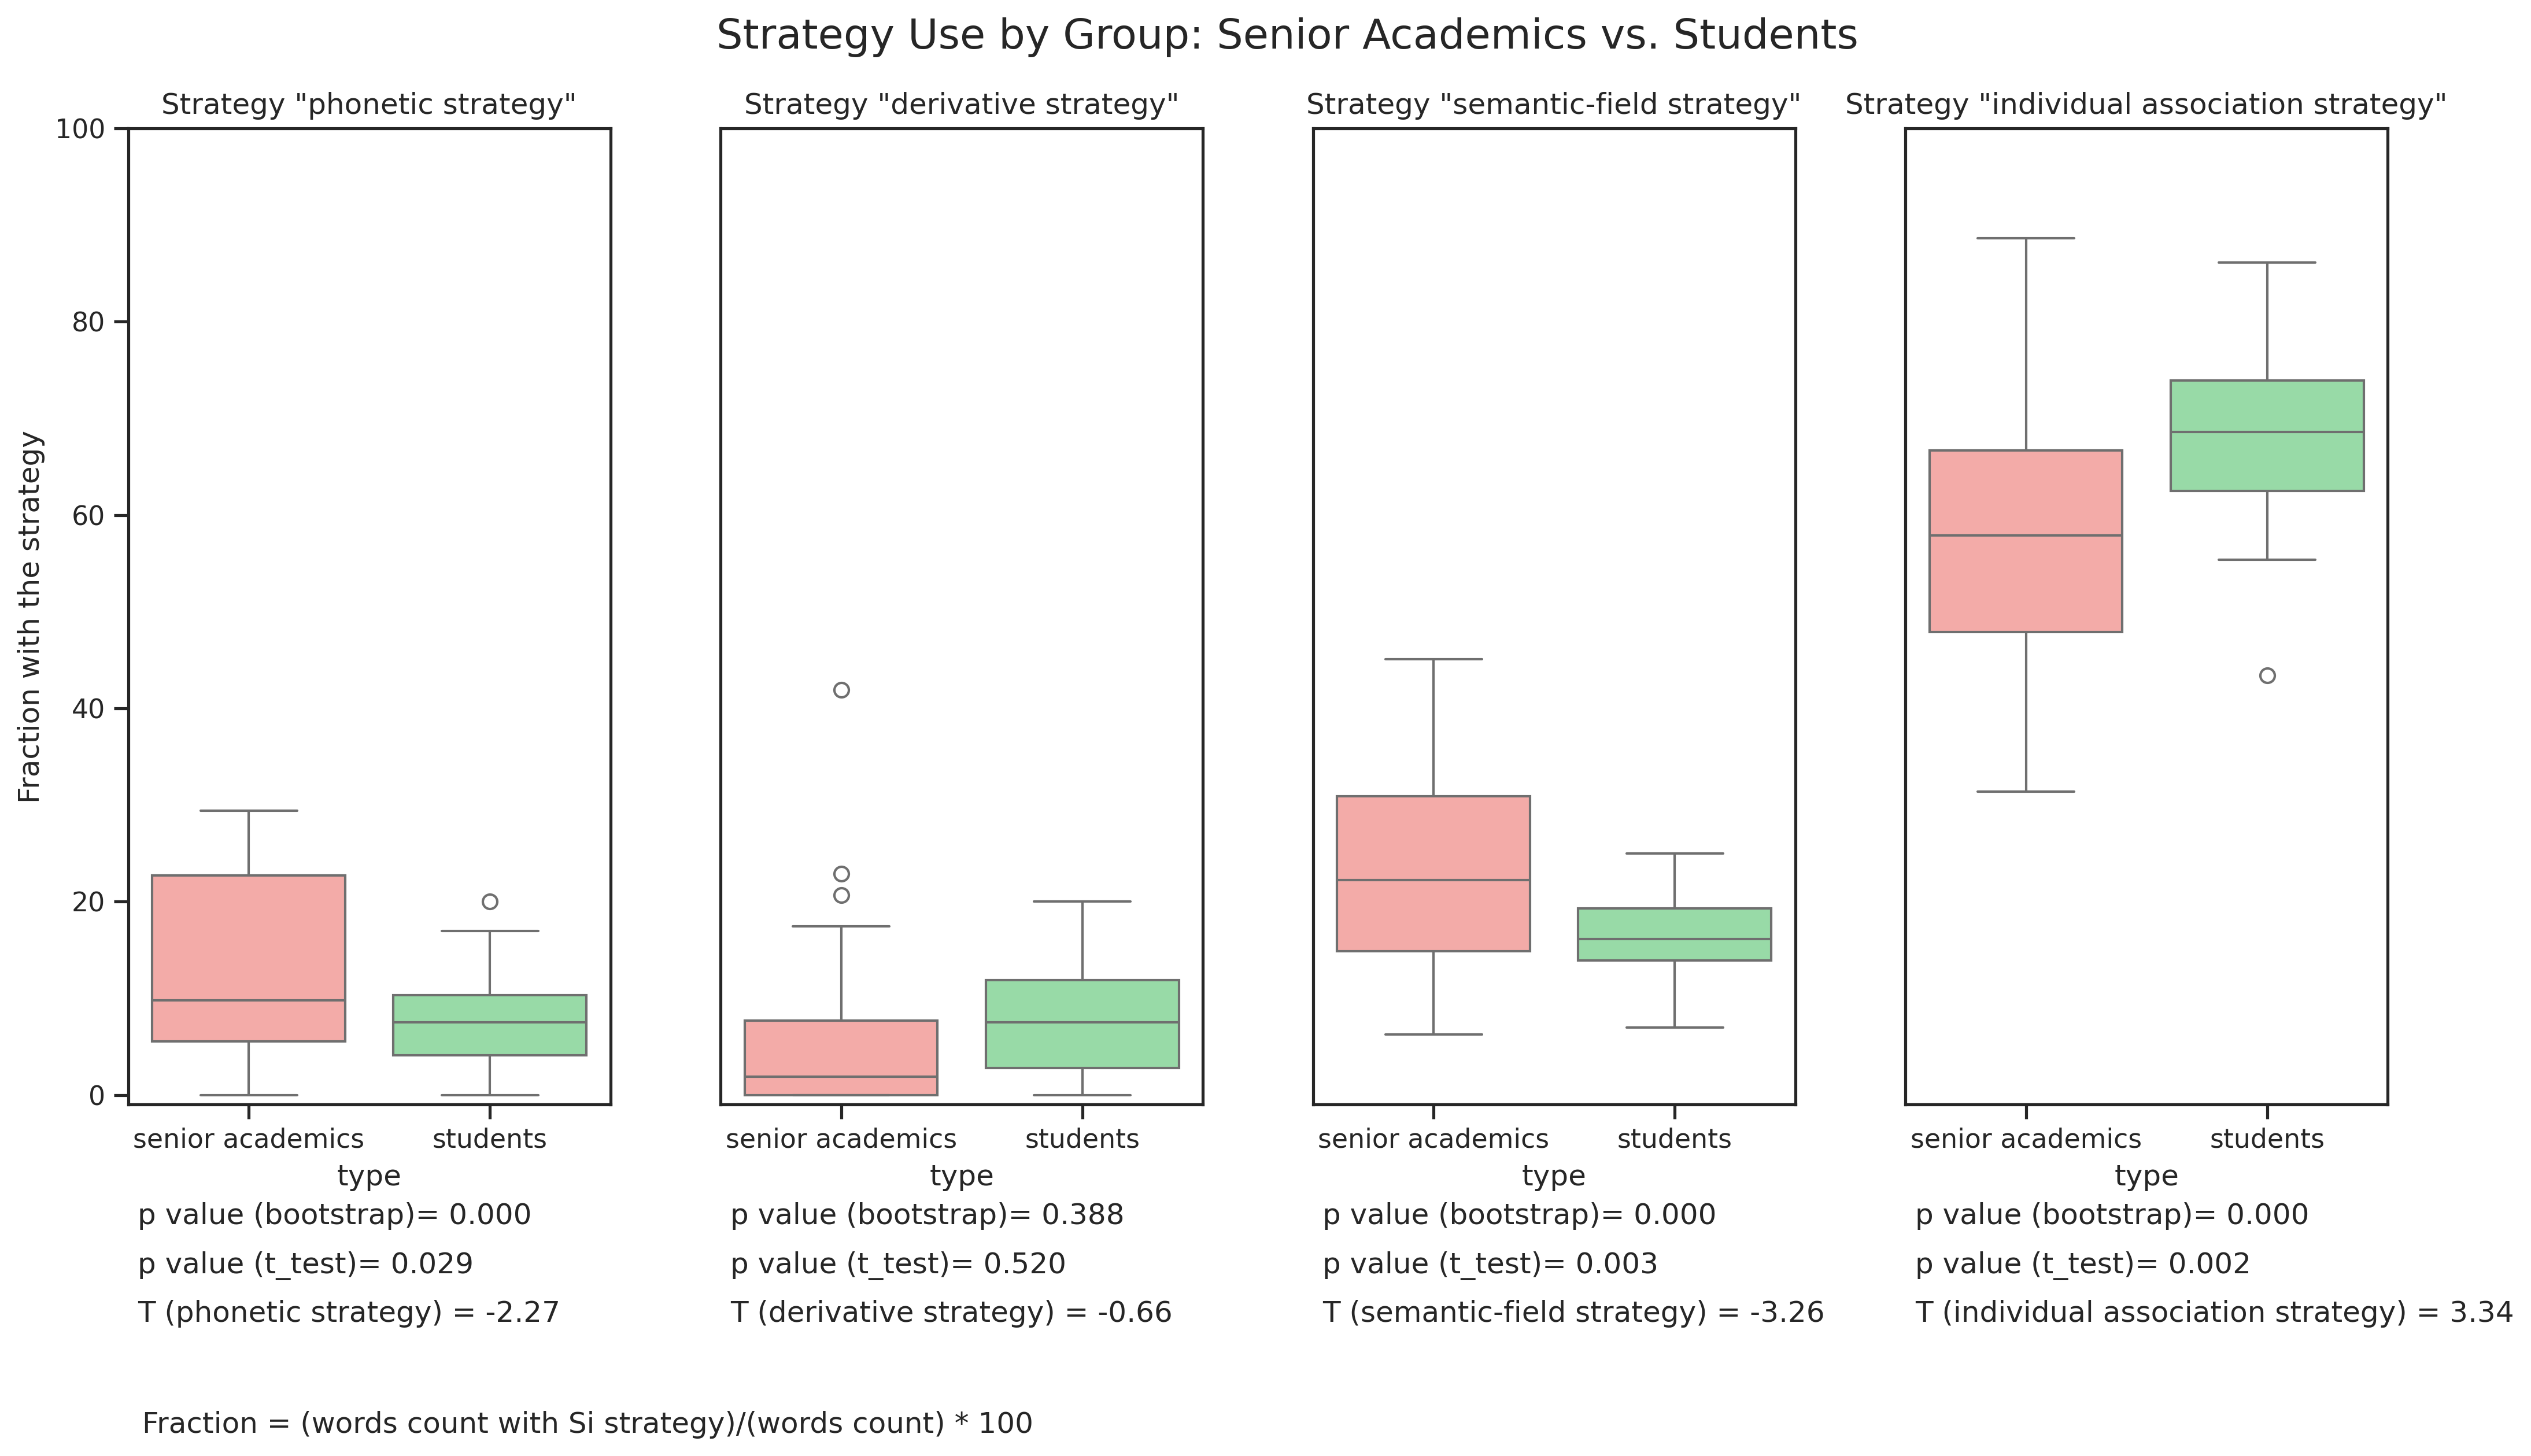

In [78]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 8), dpi=300)
j=0
for i in strategies_list:
    

    ax = sns.boxplot(strats_, y=strats_[i]*100, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
                     ,ax=axs[j]
                     );
    
    # ax.set_xlabel(f'Strategy "{i}"',    loc='left')
    ax.set_title(f'Strategy "{i}"')
    a = strats_[strats_['type']=='students'][i + '_standardized'].unique()
    b = strats_[strats_['type']!='students'][i + '_standardized'].unique()
    # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
    T, pst = stats.ttest_ind(a, b, equal_var=False)
    # ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
    # ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
    ax.text(0.02, -0.2, f"T ({i}) = {T:.2f}", ha="left", va="top", transform=ax.transAxes)
    ax.text(0.02, -0.15, f"p value (t_test)= {pst:.3f}", ha="left", va="top", transform=ax.transAxes)
    ax.text(0.02, -0.1, f"p value (bootstrap)= {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
    ax.set_ylim(-1,100)
    
    if j!=0:
        ax.set(ylabel=None)
        ax.tick_params(left=False)
        ax.set(yticklabels=[])
    else:
        ax.set(ylabel= "Fraction with the strategy")
    # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
    # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
    j+=1


# plt.xlabel('group')
# plt.title(f'Strategies between groups')
fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
fig.text(0.06, -0.04, "Fraction = (words count with Si strategy)/(words count) * 100")
plt.tight_layout()
plt.show();

# Words

In [6]:
words = pd.read_csv('words.tsv', sep='\t')

df = words.fillna('0')
# df['Стратегия'] = df['Стратегия'].str[0]
# def renamestrats(row):
#     '''
#     df['phonetic strategy'] = df['1'] 
#     df['derivation'] = df['2']
#     df['lexico-semantic field'] = df['3'] + df['4'] + df['5'] + df['6'] + df['7']
#     df['other'] = df['8']

#     '''
    
    
#     stratsfict = {'1':'fonetics', '2': 'derivation', 
#                   '8':'other', **dict.fromkeys(['n', '0'], 'None')
#                   }
#     stratsfict.update(dict.fromkeys(['3', '4', '5', '6', '7'], 'lexico-semantic field'))
#     #print(stratsfict[row['Стратегия']])
#     row['strategy_name']=stratsfict[row['Стратегия']]
#     return row

# df = df.apply(renamestrats, axis=1)
df['frequency'] = df['frequency'].astype('float', errors = 'ignore')
df['pause'] = df['pause'].astype('float', errors='ignore' )
df.head()

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,0,п,0,1.0,1,152.7,...,0,0,59,28,13,18,2.390357,students,0,0
1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,204.2,...,0,0,59,28,13,18,2.390357,students,individual association strategy,S4
2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,13.2,...,1.0,0,59,28,13,18,2.390357,students,phonetic strategy,S1
3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,12.7,...,1.0,0,59,28,13,18,2.390357,students,individual association strategy,S4
4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,5786.7,...,0,0,59,28,13,18,2.390357,students,semantic-field strategy,S3


In [7]:
words.columns

Index(['Unnamed: 0', 'ID', 'quota sec', 'word', 'previous + word',
       'first_letter', 'strategy', 'order_letter', 'order_whole_test',
       'frequency', 'pause', 'VP', 'VS', 'N of words', 'N of words_P',
       'N of words_O', 'N of words_S', 'mean pause', 'type', 'strategy_name',
       'strategy_paper_name'],
      dtype='object')

In [8]:
df[df['strategy_name']=='individual association strategy'][['type','frequency']]

,type,frequency
1,students,204.2
3,students,12.7
5,students,18.5
6,students,16.3
8,students,2.1
...,...,...
2562,senior academics,0.0
2563,senior academics,3.3
2564,senior academics,2.0
2565,senior academics,5.5


In [93]:
# df['frequency'] = pd.to_numeric(df['frequency'].str.replace(',','.'))

In [9]:
cols = df.select_dtypes('number').columns  # limits to a (float), b (int) and e (timedelta)
df_sub = df.loc[:, 'frequency']


# OPTION 1: z-score filter: z-score < 3
#lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

# OPTION 2: quantile filter: discard 1% upper / lower values
#lim = np.logical_and(df_sub < df_sub.quantile(0.99, numeric_only=False),
#                     df_sub > df_sub.quantile(0.01, numeric_only=False))

# OPTION 3: iqr filter: within 2.22 IQR (equiv. to z-score < 3)
iqr = df_sub.quantile(0.75) - df_sub.quantile(0.25)
lim = np.abs((df_sub - df_sub.median()) / iqr) < 2.22


# replace outliers with nan
df.loc[:, 'frequency'] = df_sub.where(lim, np.nan)
df = df.reset_index() #важная часть кода
df["frequency"] = df["frequency"].fillna(220)
dfj = df[df['strategy_name'] !='None']

dfj['Word frequency'] = (dfj['frequency'])

In [10]:
dfj['strategy_name'].unique()

array(['0', 'individual association strategy', 'phonetic strategy',
       'semantic-field strategy', 'derivative strategy'], dtype=object)

In [11]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [12]:
# dfj['Pause duration'] = pd.to_numeric(dfj['pause'].str.replace(',','.'))
dfj['Pause duration'] = dfj['pause']

In [13]:
dfjj = dfj[dfj['strategy_name'].isin(strategies_list)]

In [14]:
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

## Pause duration

S1. Phonetic strategy

S2. Derivative strategy

S3. Semantic-field strategy

S4. Individual association strategy

In [86]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
#     pval.append(p_value)
#     es.append(cohens_d)
    

In [15]:
dfjj.head()

,index,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,...,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name,Word frequency,Pause duration
1,1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,...,59,28,13,18,2.390357,students,individual association strategy,S4,220.0,0.10
2,2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,...,59,28,13,18,2.390357,students,phonetic strategy,S1,13.2,3.15
3,3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,...,59,28,13,18,2.390357,students,individual association strategy,S4,12.7,1.00
4,4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,...,59,28,13,18,2.390357,students,semantic-field strategy,S3,220.0,0.70
5,5,5,Б_В_10,1,повреждение,"['по', 'повреждение']",п,8,6.0,6,...,59,28,13,18,2.390357,students,individual association strategy,S4,18.5,3.34


In [16]:
sorted(dfjj['strategy_paper_name'].unique())

['S1', 'S2', 'S3', 'S4']

In [30]:
dfj_s = dfjj[['type','Pause duration', 'strategy_paper_name']]

In [32]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

S1


/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std


Observed difference (standardized): -0.26070611154974427
CI for observed difference [-0.4805778759056475, -0.04083434719384105]
Cohen's d (effect size): -0.26229525938842974
bootstrap p-value: 0.0052
H0 Confidence interval (95%): [-0.17767365  0.19312729]
Expected mean diffs are not normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


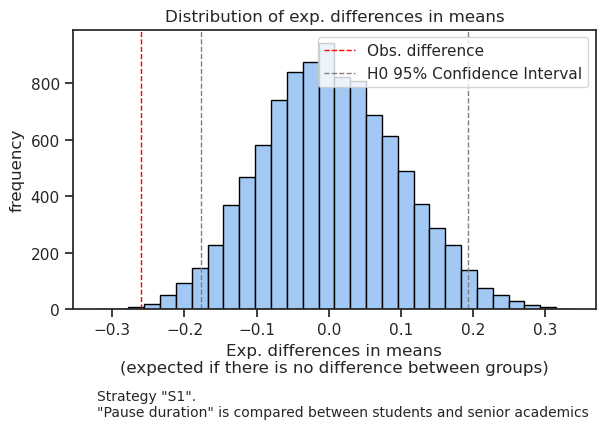



S2


/tmp/ipykernel_762/2402805706.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfj_boot = pd.concat([dfj_boot, tempdf])
/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std


Observed difference (standardized): 0.4005213069271152
CI for observed difference [0.1236652112008263, 0.6773774026534041]
Cohen's d (effect size): 0.4077457415111397
bootstrap p-value: 0.0
H0 Confidence interval (95%): [-0.2006504   0.19845768]
Expected mean diffs are not normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


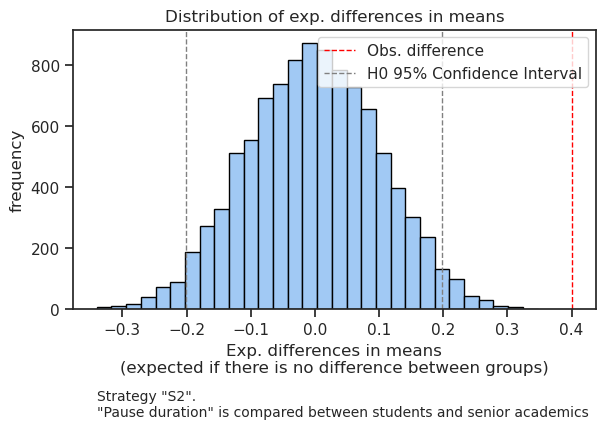

/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std




S3
Observed difference (standardized): -0.030567783375676134
CI for observed difference [-0.21092616307485368, 0.1497905963235014]
Cohen's d (effect size): -0.030539042264560445
bootstrap p-value: 0.6387
H0 Confidence interval (95%): [-0.12618396  0.13283959]
Expected mean diffs are not normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


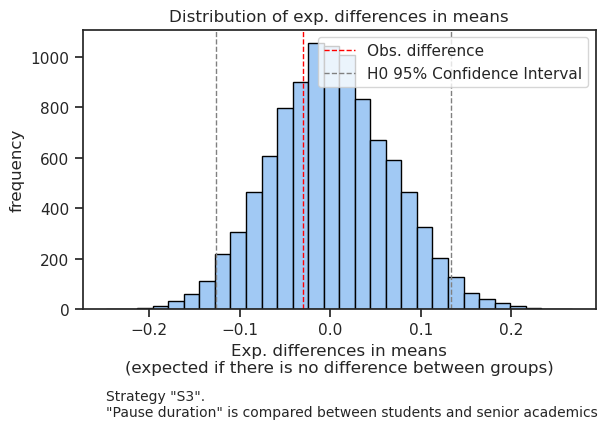

/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std




S4
Observed difference (standardized): 0.05623744392880273
CI for observed difference [-0.04462919370218152, 0.15710408155978697]
Cohen's d (effect size): 0.056240723794369875
bootstrap p-value: 0.1289
H0 Confidence interval (95%): [-0.07299683  0.07396154]
Expected mean diffs are normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


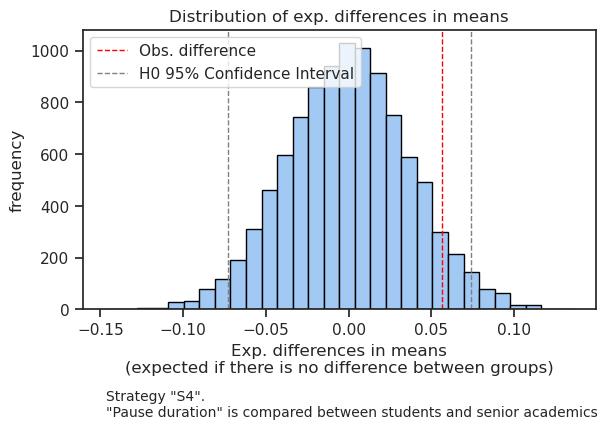

In [31]:
conf_interval = []
pval = []
es = []
dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'Pause duration'])
for i in sorted(dfj_s['strategy_paper_name'].unique()):
    if i!='0':
        print(i)
        tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
        ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(tempdf, 'Pause duration', f'Strategy "{i}".\n')
        dfj_boot = pd.concat([dfj_boot, tempdf])
        conf_interval.append(ci)
        pval.append(p_value)
        es.append(cohens_d)
        print('\n')

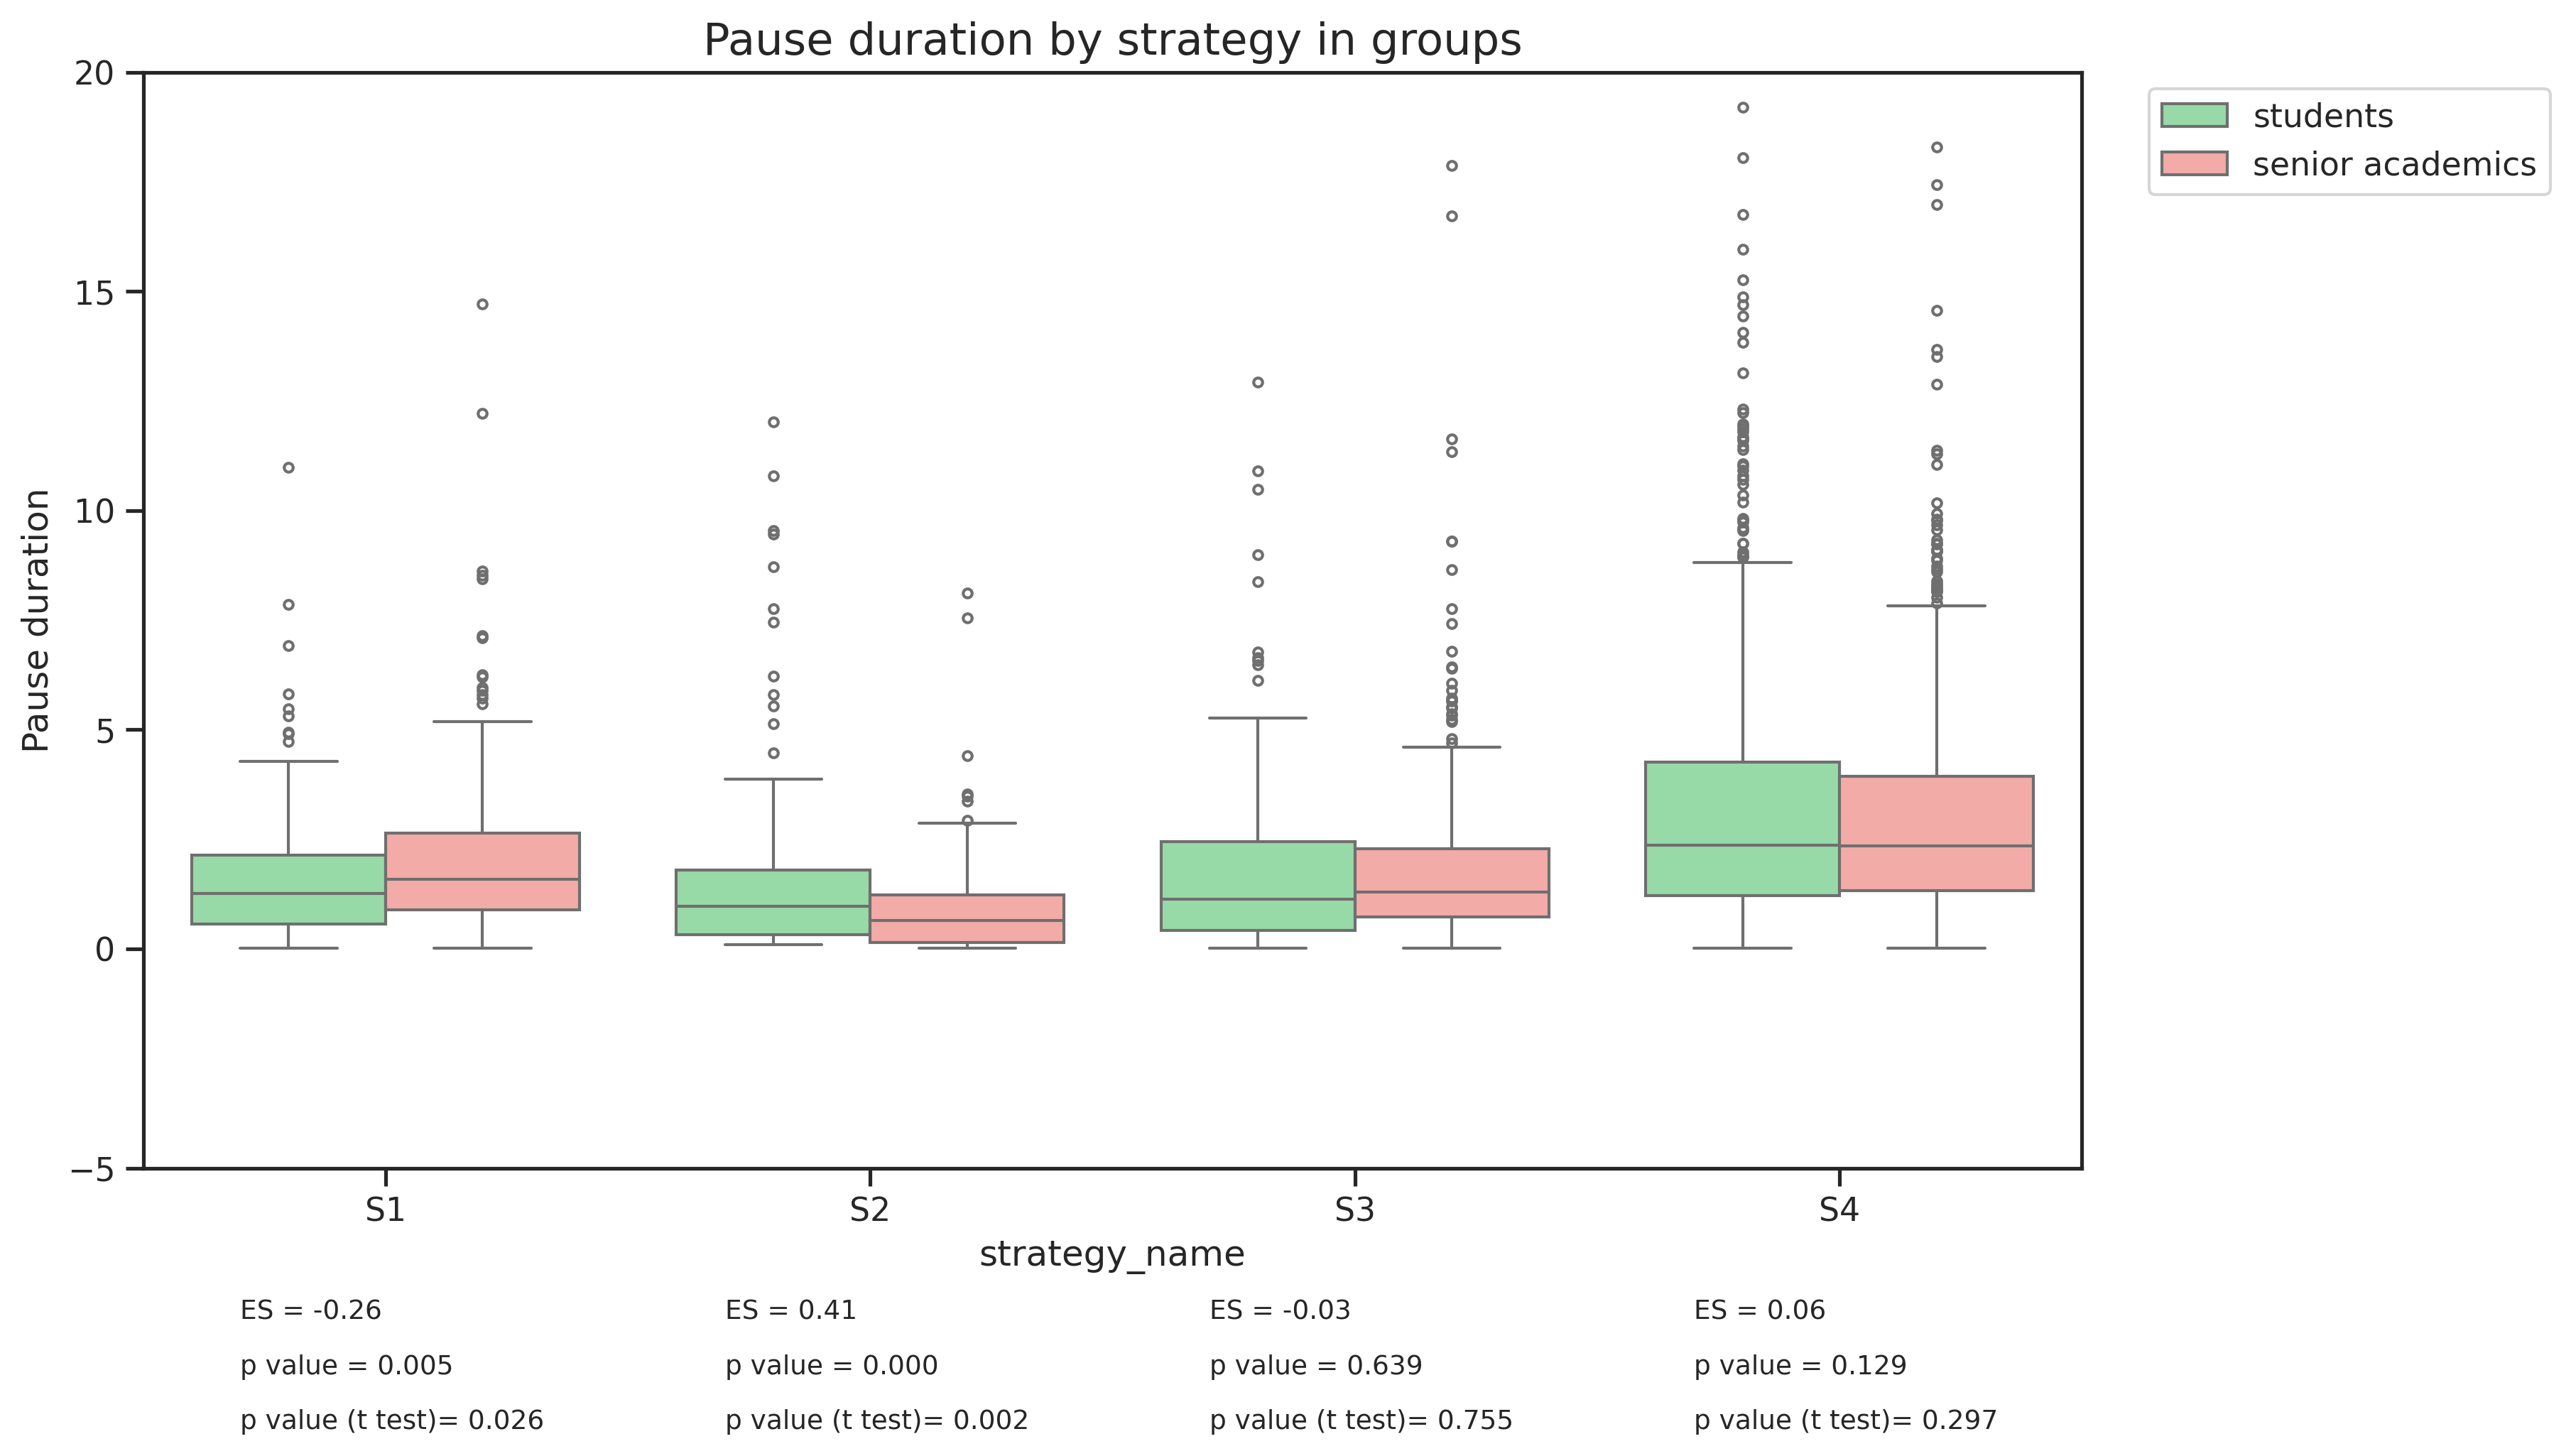

In [69]:
fig = plt.figure(figsize=(10, 6), dpi=300)
sns.set_theme(style="ticks", palette="pastel")
g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Pause duration', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
plt.tight_layout()
g.legend( bbox_to_anchor=(1.25, 1))
plt.ylim((-5,20))

for i in range(len(es)):
      a = dfj_boot[(dfj_boot['type']!='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Pause duration' + '_standardized'].values
      b = dfj_boot[(dfj_boot['type']=='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Pause duration' + '_standardized'].values
      # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
      T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=1000)

      g.text(i*0.25+0.05, -0.12, f"ES = {es[i]:.2f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      g.text(i*0.25+0.05, -0.17, f"p value = {pval[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value (t test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
    
# g.legend( bbox_to_anchor=(0.832, 0.85))
# fig.suptitle('Word frequency by strategy in groups', fontsize=15)
g.set_title('Pause duration by strategy in groups', fontdict={'fontsize': 15, 'fontweight': 'medium'})
plt.xlabel('strategy_name')
plt.show()

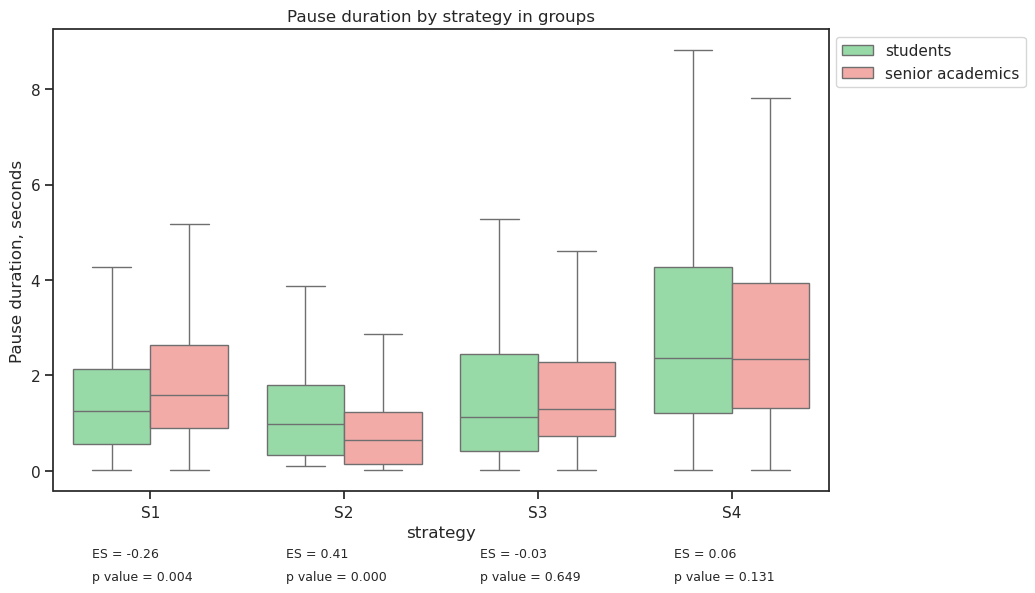

In [27]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="ticks", palette="pastel")
g = sns.boxplot(data = dfjj.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Pause duration', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.xlabel('strategy')
plt.ylabel('Pause duration, seconds')
plt.title(f'Pause duration by strategy in groups')


# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(es)):
      g.text(i*0.25+0.05, -0.12, f"ES = {es[i]:.2f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      g.text(i*0.25+0.05, -0.17, f"p value = {pval[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
    
g.legend( bbox_to_anchor=(1, 1))

In [28]:
dict_for_strategy_names_paper = {'phonetic strategy': 'S1',
                                 'derivative strategy': 'S2',
                                 'semantic-field strategy': 'S3',
                                 'individual association strategy': 'S4'
}

## word frequency

/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std
/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


Observed difference (standardized): 0.11770061447801061
CI for observed difference [0.04051062144251377, 0.19489060751350745]
Cohen's d (effect size): 0.1178820621621851
bootstrap p-value: 0.0002
H0 Confidence interval (95%): [-0.05433244  0.05472071]
Expected mean diffs are normal disrtibuted


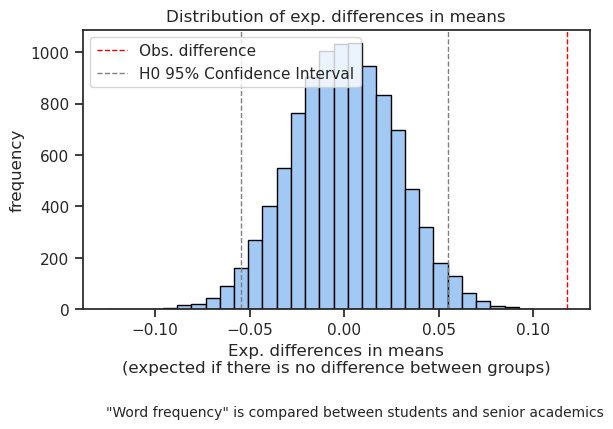

In [30]:
ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(dfj[['type','Word frequency']], 'Word frequency')

### **between strategies**

In [ ]:
dfj_s = dfjj[['type','Word frequency']]

/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std


Observed difference (standardized): 0.12273766893234103
CI for observed difference [0.04310517069755225, 0.2023701671671298]
Cohen's d (effect size): 0.12294402882274161
bootstrap p-value: 0.0
H0 Confidence interval (95%): [-0.0565412   0.05776579]
Expected mean diffs are normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


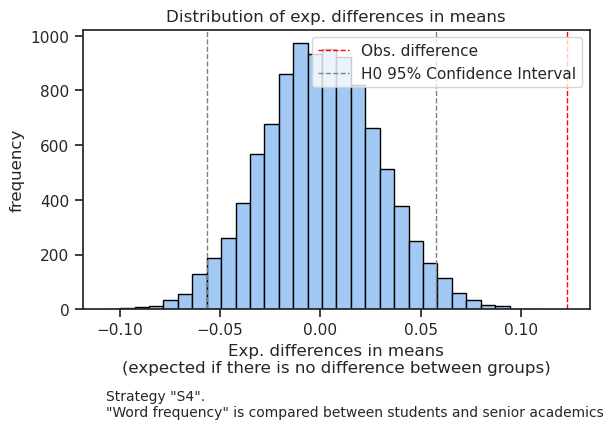

(array([-0.0565412 ,  0.05776579]),
 0.0,
 0.12273766893234103,
 [0.04310517069755225, 0.2023701671671298],
 0.12294402882274161)

In [ ]:
full_bootstrap_mean_diff(dfj_s, 'Word frequency', f'Strategy "{i}".\n')

In [18]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

In [ ]:
dfj_boot = dfjj[['type','Word frequency', 'strategy_paper_name']]

S1


/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std


Observed difference (standardized): 0.058784918827033183
CI for observed difference [-0.19756264521965006, 0.3151324828737164]
Cohen's d (effect size): 0.058688871496781245
bootstrap p-value: 0.5397
H0 Confidence interval (95%): [-0.18665201  0.18773523]
Expected mean diffs are normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


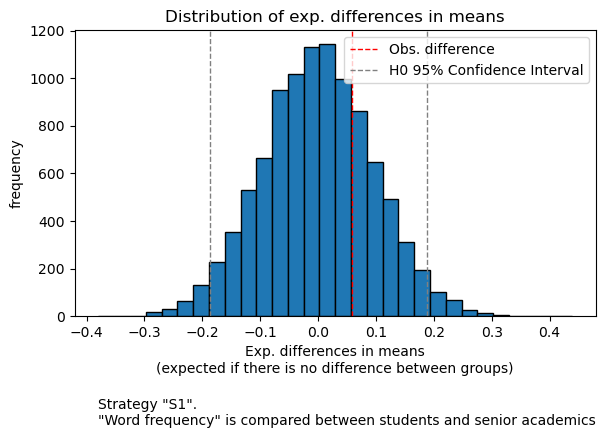

/tmp/ipykernel_762/510902756.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfj_boot = pd.concat([dfj_boot, tempdf])
/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std




S2
Observed difference (standardized): 0.26884649136897343
CI for observed difference [-0.013771414233298418, 0.5514643969712453]
Cohen's d (effect size): 0.27059132229820704
bootstrap p-value: 0.0076
H0 Confidence interval (95%): [-0.2036166   0.19800008]
Expected mean diffs are normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


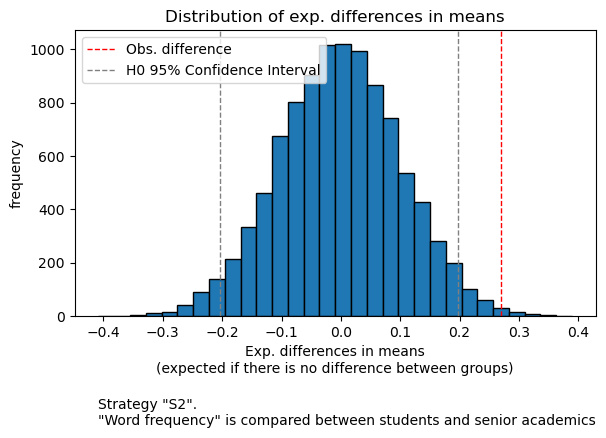

/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std




S3


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


Observed difference (standardized): 0.15903940245903722
CI for observed difference [-0.024685092094691524, 0.342763897012766]
Cohen's d (effect size): 0.1593603046512933
bootstrap p-value: 0.0182
H0 Confidence interval (95%): [-0.12983475  0.12965439]
Expected mean diffs are normal disrtibuted


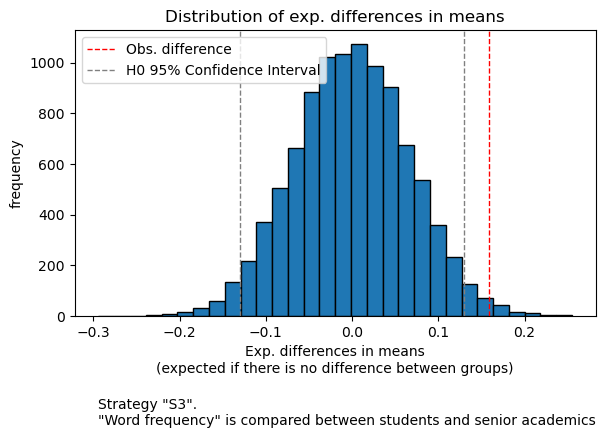



S4


/home/aryuna/work/sharapkova/pos_febr/stats.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column + '_standardized'] = (df[column] - mean) / std


Observed difference (standardized): 0.13023920842930364
CI for observed difference [0.02939399883069707, 0.23108441802791022]
Cohen's d (effect size): 0.13046985274667228
bootstrap p-value: 0.0005
H0 Confidence interval (95%): [-0.07202257  0.07323339]
Expected mean diffs are normal disrtibuted


/home/aryuna/work/sharapkova/pos_febr/stats.py:31: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  shap, p = stats.shapiro(mean_diffs)


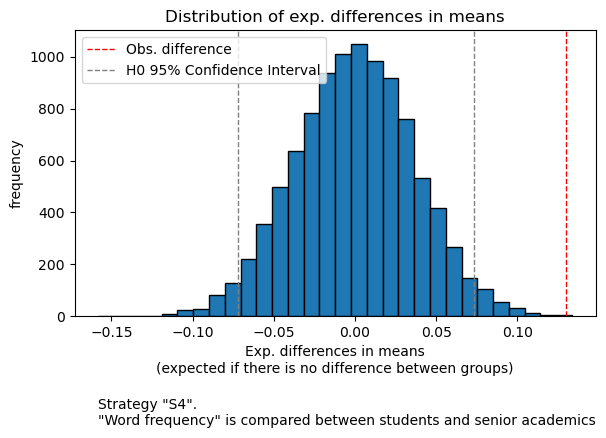

In [ ]:
conf_interval = []
pval = []
es = []
dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'strategy_paper_name'])
for i in st_paper_n_list:
    print(i)
    tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
    
    ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(tempdf, 'Word frequency', f'Strategy "{i}".\n')
    dfj_boot = pd.concat([dfj_boot, tempdf])
    conf_interval.append(ci)
    pval.append(p_value)
    es.append(cohens_d)
    print('\n')

In [25]:
dfj_boot

,type,Word frequency,strategy_paper_name,Word frequency_standardized
2,students,13.2,S1,-0.542463
34,students,220.0,S1,2.169959
35,students,220.0,S1,2.169959
37,students,0.6,S1,-0.707727
49,students,2.9,S1,-0.677559
...,...,...,...,...
2562,senior academics,0.0,S4,-0.763125
2563,senior academics,3.3,S4,-0.716990
2564,senior academics,2.0,S4,-0.735164
2565,senior academics,5.5,S4,-0.686233


In [26]:
dfj_boot['Word frequency_standardized']

2      -0.542463
34      2.169959
35      2.169959
37     -0.707727
49     -0.677559
          ...   
2562   -0.763125
2563   -0.716990
2564   -0.735164
2565   -0.686233
2567   -0.588370
Name: Word frequency_standardized, Length: 2412, dtype: float64

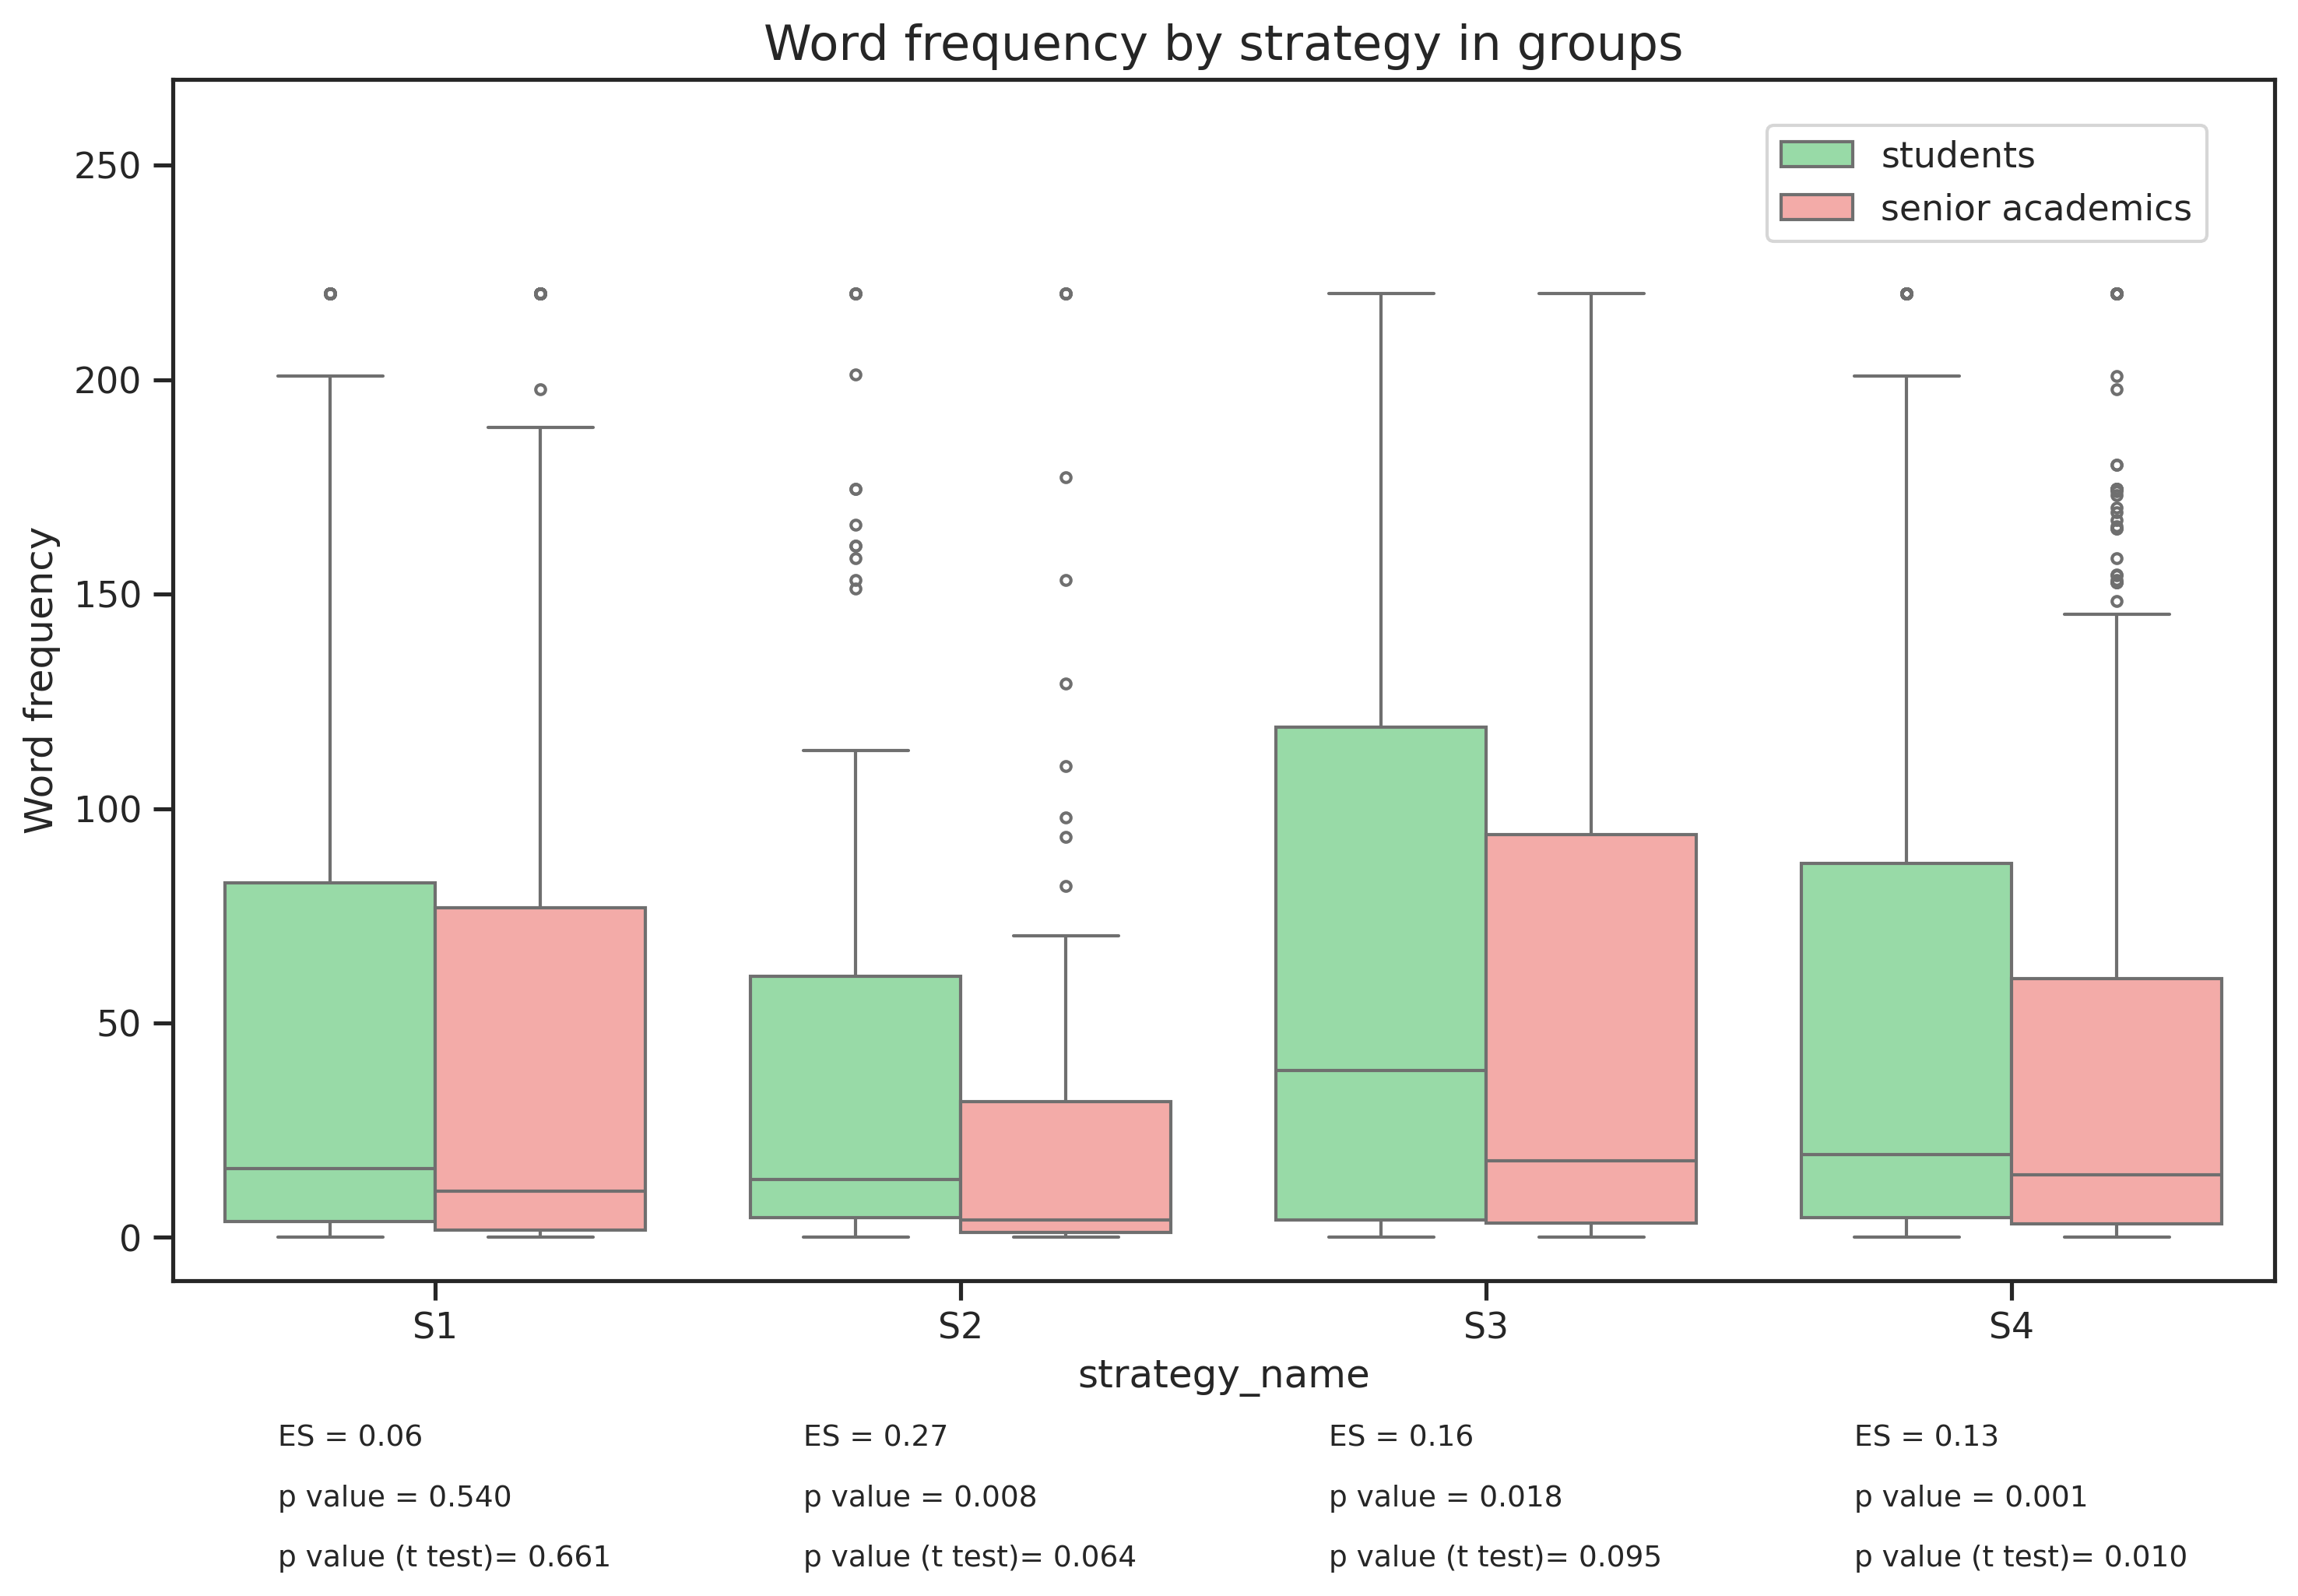

In [29]:
fig = plt.figure(figsize=(10, 6), dpi=300)
sns.set_theme(style="ticks", palette="pastel")
g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
plt.tight_layout()
g.legend( bbox_to_anchor=(1.28, 1))
plt.ylim((-10,270))

for i in range(len(es)):
      a = dfj_boot[(dfj_boot['type']!='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
      b = dfj_boot[(dfj_boot['type']=='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
      # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
      T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)

      g.text(i*0.25+0.05, -0.12, f"ES = {es[i]:.2f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      g.text(i*0.25+0.05, -0.17, f"p value = {pval[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value (t test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
    
g.legend( bbox_to_anchor=(0.75, 0.85))
# fig.suptitle('Word frequency by strategy in groups', fontsize=15)
g.set_title('Word frequency by strategy in groups', fontdict={'fontsize': 15, 'fontweight': 'medium'})
plt.xlabel('strategy_name')
plt.show()

# RT